# Imports

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

# Это нужно, если запускаем из папки notebooks
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

# Импортируем наш конфиг
from utils.config import cfg

# Проверяем, что всё подхватилось
print(cfg)

# --- ИСПОЛЬЗОВАНИЕ ---

# 1. Параметры из конфига
QUANTILES = cfg.QUANTILES
FORECAST_HORIZON = cfg.FORECAST_HORIZON

# 2. Загрузка данных (логика выбора)
DATA = None

if cfg.SERIES_TYPE == "PASSENGERS":
    # Используем путь из конфига!
    csv_path = cfg.INPUT_DIR / "air-passengers.csv"
    print(f"Loading from: {csv_path}")
    
    passengers_df = pd.read_csv(csv_path)
    DATA = passengers_df[cfg.SERIES_ID].values 
    print(f"Loaded Passengers data. Length: {len(DATA)}")

elif cfg.SERIES_TYPE == "M5":
    csv_path = cfg.INPUT_DIR / "sales_train_evaluation.csv" 
    print(f"Loading M5 from: {csv_path}")
    
    m5_df = pd.read_csv(csv_path)
    
    series_row = m5_df[m5_df["id"] == cfg.SERIES_ID]

    calendar = pd.read_csv(cfg.INPUT_DIR / "calendar.csv")

    
    if series_row.empty:
        raise ValueError(f"Series ID '{cfg.SERIES_ID}' not found in M5 dataset!")
        
    DATA = series_row.filter(like='d_').values[0]
    print(f"Loaded M5 series '{cfg.SERIES_ID}'. Length: {len(DATA)}")

else:
    raise ValueError(f"Unknown cfg.SERIES_TYPE: {cfg.cfg.SERIES_TYPE}")

ProjectConfig(
  Environment: Local,
  Input Dir: d:\quantile_regression\m5-forecasting-uncertainty\data,
  Output Dir: d:\quantile_regression\m5-forecasting-uncertainty\output,
  Series Type: PASSENGERS,
  Series ID: Passengers,
  Horizon: 28,
  Quantiles: [0.05, 0.25, 0.5, 0.75, 0.95]
)
Loading from: d:\quantile_regression\m5-forecasting-uncertainty\data\air-passengers.csv
Loaded Passengers data. Length: 144


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

SEED=12
np.random.seed(SEED)


In [19]:
# #1337 HOUSEHOLD_2_242_CA_1_evaluation ряд шумный
# #28581 HOUSEHOLD_2_242_CA_1_evaluation только тренд
# #30426 FOODS_3_764_WI_3_evaluation трендом, сезонностю(годовая) + шум
# #2810 FOODS_3_586_CA_1_evaluation сезонность(годовая) + шум
# #air-passengers тренд + сезонность(месячная)
# plot_series([30426], with_stl_decomposition=True)

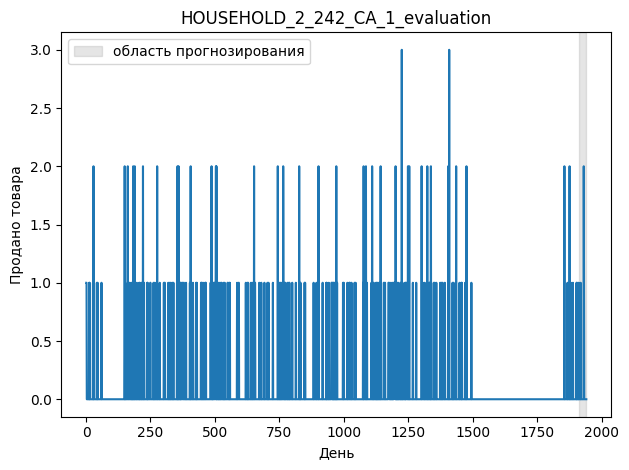

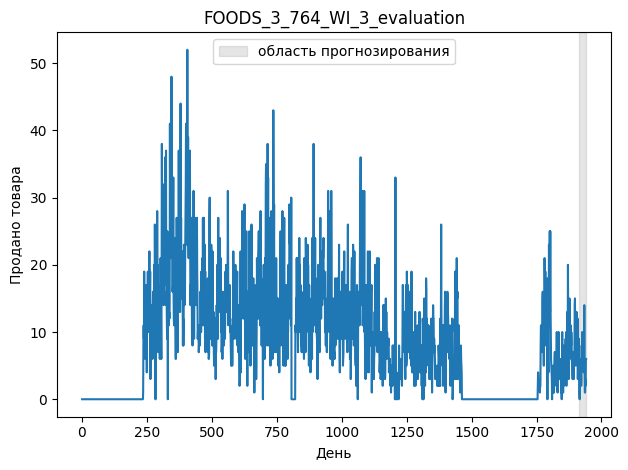

In [ ]:
# def plot_m5_data(list_of_series_id: list) -> dict:
#     for series_id in list_of_series_id:
#         series_data = m5_data[m5_data["id"] == series_id].filter(like='d_').values.flatten()
#         plt.plot(np.arange(1, len(series_data)+1), series_data)
#         plt.title(series_id)
#         plt.xlabel('День')
#         plt.ylabel('Продано товара')
#         plt.axvspan(len(series_data) - 28, len(series_data), color='#808080', alpha=0.2, label='область прогнозирования')
#         plt.legend()
#         plt.tight_layout()
#         plt.show()

# list_of_series_id = [
#     "HOUSEHOLD_2_242_CA_1_evaluation",
#     "FOODS_3_764_WI_3_evaluation"
# ]
# plot_m5_data(list_of_series_id)

# Prophet

Начинаем подбор параметров...


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 4.809839725494385


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.532834053039551


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.188960552215576


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 4.6997230052948


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 4.830196857452393


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 4.450379371643066


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.112545967102051


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:28:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.267983436584473


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.718085527420044


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 4.082030534744263


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 4.032512664794922


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 3.8187148571014404


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
17:29:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 iterations at max treedepth (11.3%)
	Chain 2 had 4 iterations at max treedepth (2.7%)
	Chain 3 had 1 iterations at max treedepth (0.7%)
	Chain 4 had 3 iterations at max treedepth (2.0%)
	Use the "diagnose(


FIT TIME: 8.715867280960083


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
17:29:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 25 iterations at max treedepth (16.7%)
	Chain 3 had 9 iterations at max treedepth (6.0%)
	Chain 4 had 6 iterations at max treedepth (4.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to


FIT TIME: 9.44002652168274


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
17:29:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 iterations at max treedepth (4.7%)
	Chain 2 had 23 iterations at max treedepth (15.3%)
	Chain 3 had 1 iterations at max treedepth (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see furth


FIT TIME: 7.454209327697754


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.328792333602905


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:29:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 6.345881700515747


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:30:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!



FIT TIME: 5.398083209991455
Лучшие параметры: {'changepoint_prior_scale': 0.05, 'mcmc_samples': 300, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:30:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:30:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
17:30:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:30:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]

17:31:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
17:31:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.




Результаты Pinball Loss:
Quantile 0.1: 4.1038
Quantile 0.25: 6.9113
Quantile 0.5: 8.0953
Quantile 0.75: 6.1989
Quantile 0.9: 3.4065


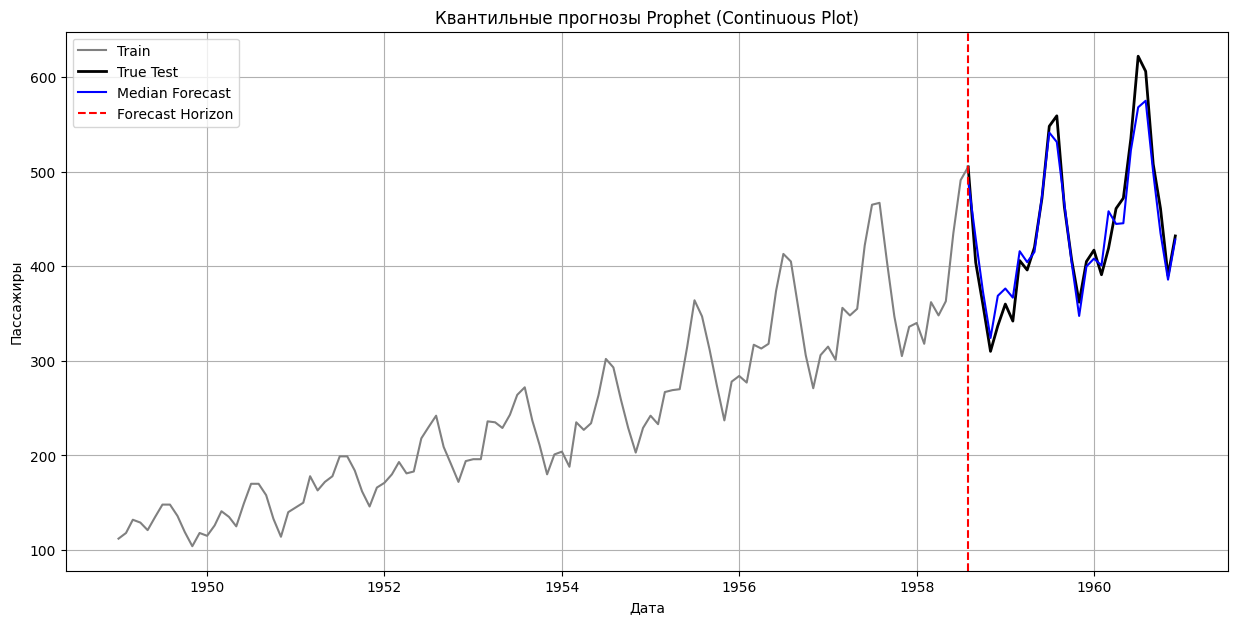

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_pinball_loss
import time

# 1. Подготовка данных
data = pd.DataFrame()
if cfg.SERIES_TYPE == "PASSENGERS":
    data['ds'] = pd.to_datetime(passengers_df["Month"])
elif cfg.SERIES_TYPE == "M5":
    data["ds"] = calendar["date"].iloc[:-28]
data['y'] = DATA
prophet_freq = "MS" if cfg.SERIES_TYPE=="PASSENGERS" else "D"

# Разбиение
train_size = len(DATA) - FORECAST_HORIZON * 2 #забираю FORECAST_HORIZON * 2 в тест, чтобы не переобучиться с перебором параметров для grid_search
train, grid_search_test, final_test = data.iloc[:train_size], data.iloc[train_size:train_size + FORECAST_HORIZON], data.iloc[train_size + FORECAST_HORIZON:]


# --- Функция метрики (Pinball Loss) ---
def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

# --- 2. Подбор гиперпараметров (без изменений) ---
params_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1], 
    'seasonality_prior_scale': [1.0, 5., 10.0],
    'mcmc_samples': [300]
}

grid = ParameterGrid(params_grid)
best_params = {}
best_score = float('inf')

# Используем suppress output, чтобы не засорять лог
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("Начинаем подбор параметров...")


for p in grid:
    m = Prophet(**p)
    start_time = time.time()
    m.fit(train)
    print(f'FIT TIME: {time.time() - start_time}')
    future = m.make_future_dataframe(periods=FORECAST_HORIZON, freq=prophet_freq)
    forecast = m.predict(future)
    preds = forecast['yhat'].tail(FORECAST_HORIZON).values
    mae = mean_absolute_error(grid_search_test['y'], preds)
    
    if mae < best_score:
        best_score = mae
        best_params = p

print(f"Лучшие параметры: {best_params}")
#меняем train
train = pd.concat([train, grid_search_test])

# --- 3. Построение Квантильных Прогнозов ---
target_quantiles = [0.10, 0.25, 0.5, 0.75, 0.90]

# Словари для хранения результатов
prophet_quantile_predictions = {} # Для расчета метрик (ровно 28 точек)
quantile_plots = {}   # Для графиков (29 точек, чтобы склеить линию)

# Вспомогательный словарь для ширины интервалов
interval_maps = {0.80: (0.10, 0.90), 0.50: (0.25, 0.75)}

# Генерируем future (один раз)
m_temp = Prophet(**best_params).fit(train)
future = m_temp.make_future_dataframe(periods=FORECAST_HORIZON, freq=prophet_freq)

# 1. Медиана (0.5)
model_median = Prophet(**best_params) 
model_median.fit(train)
fcst_median = model_median.predict(future)

# Сохраняем для метрик (28 точек)
prophet_quantile_predictions[0.5] = fcst_median['yhat'].tail(FORECAST_HORIZON).values
# Сохраняем для графика (29 точек = 1 точка истории + 28 точек теста)
quantile_plots[0.5] = fcst_median['yhat'].tail(FORECAST_HORIZON + 1).values

# 2. Интервалы
for width, (q_low, q_high) in interval_maps.items():
    m = Prophet(interval_width=width, **best_params)
    m.fit(train)
    fcst = m.predict(future)
    
    # Для метрик
    prophet_quantile_predictions[q_low] = fcst['yhat_lower'].tail(FORECAST_HORIZON).values
    prophet_quantile_predictions[q_high] = fcst['yhat_upper'].tail(FORECAST_HORIZON).values
    
    # Для графика (захватываем +1 точку с конца обучения)
    quantile_plots[q_low] = fcst['yhat_lower'].tail(FORECAST_HORIZON + 1).values
    quantile_plots[q_high] = fcst['yhat_upper'].tail(FORECAST_HORIZON + 1).values

# --- 4. Оценка и Визуализация ---

# Оценка (используем prophet_quantile_predictions - 28 точек)
print("\nРезультаты Pinball Loss:")
for q in target_quantiles:
    loss = mean_pinball_loss(final_test['y'].values, prophet_quantile_predictions[q], alpha=q)
    print(f"Quantile {q}: {loss:.4f}")

# Визуализация (используем quantile_plots - 29 точек)
plt.figure(figsize=(15, 7))

# Рисуем весь ряд "True" одной линией для красоты, или разбиваем на Train/Test
plt.plot(train['ds'], train['y'], label='Train', color='gray')
plt.plot(data['ds'].tail(FORECAST_HORIZON + 1), data['y'].tail(FORECAST_HORIZON + 1), label='True Test', color='black', linewidth=2)

# Подготавливаем даты для графика (последняя дата train + все даты test)
plot_dates = data['ds'].tail(FORECAST_HORIZON + 1)

# Рисуем квантили (теперь они начинаются от линии горизонта)
# 5% - 95%
# plt.fill_between(plot_dates, 
#                  quantile_plots[0.10], 
#                  quantile_plots[0.90], 
#                  color='lightblue', alpha=0.3, label='90% confidence')

# 25% - 75%
# plt.fill_between(plot_dates, 
#                  quantile_plots[0.25], 
#                  quantile_plots[0.75], 
#                  color='blue', alpha=0.3, label='50% confidence')

# Медиана
plt.plot(plot_dates, quantile_plots[0.5], color='blue', label='Median Forecast')

plt.axvline(x=train['ds'].iloc[-1], color='red', linestyle='--', label='Forecast Horizon')
plt.title('Квантильные прогнозы Prophet (Continuous Plot)')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()
plt.grid(True)
plt.show()

# AutoArima

In [24]:
from sktime.forecasting.arima import AutoARIMA
#sp = 7 - дневой стемп, sp=12 - месяца
sp = 7 if cfg.SERIES_TYPE == "M5" else 12
y=DATA
train_data = y[:-28]
model = AutoARIMA(sp=sp, max_p=100, max_q=100, suppress_warnings=True, random_state=413)

from tqdm import tqdm
rolling_model = AutoARIMA(sp=sp, max_p=100, max_q=100, suppress_warnings=True, random_state=413)
rolling_model.fit(train_data)
q = rolling_model.get_fitted_params()['order'][-1]
print('порядок MA(q): {q}'.format(q=q))
rolling_pred = [rolling_model.predict(fh=np.arange(1, max(q, 1)+1))]

rolling_quantile_pred = [rolling_model.predict_quantiles(fh=np.arange(1, max(q, 1)+1), alpha=QUANTILES)]

for i in tqdm(range(len(train_data) + max(q, 1), len(y), max(q, 1))):
    rolling_model.fit(y[:i])
    rolling_pred.append(rolling_model.predict(fh=list(range(1, max(q, 1)+1))))
    rolling_quantile_pred.append(rolling_model.predict_quantiles(fh=np.arange(1, max(q, 1)+1), alpha=QUANTILES))
    
rolling_quantile_pred = pd.concat(rolling_quantile_pred)
rolling_pred = np.concatenate(rolling_pred).flatten()

порядок MA(q): 0


















































 56%|█████▌    | 15/27 [03:07<02:29, 12.48s/it]


KeyboardInterrupt: 

rolling pl: [3.86069289 5.86495555 7.13782285 5.4400992  3.35542371]



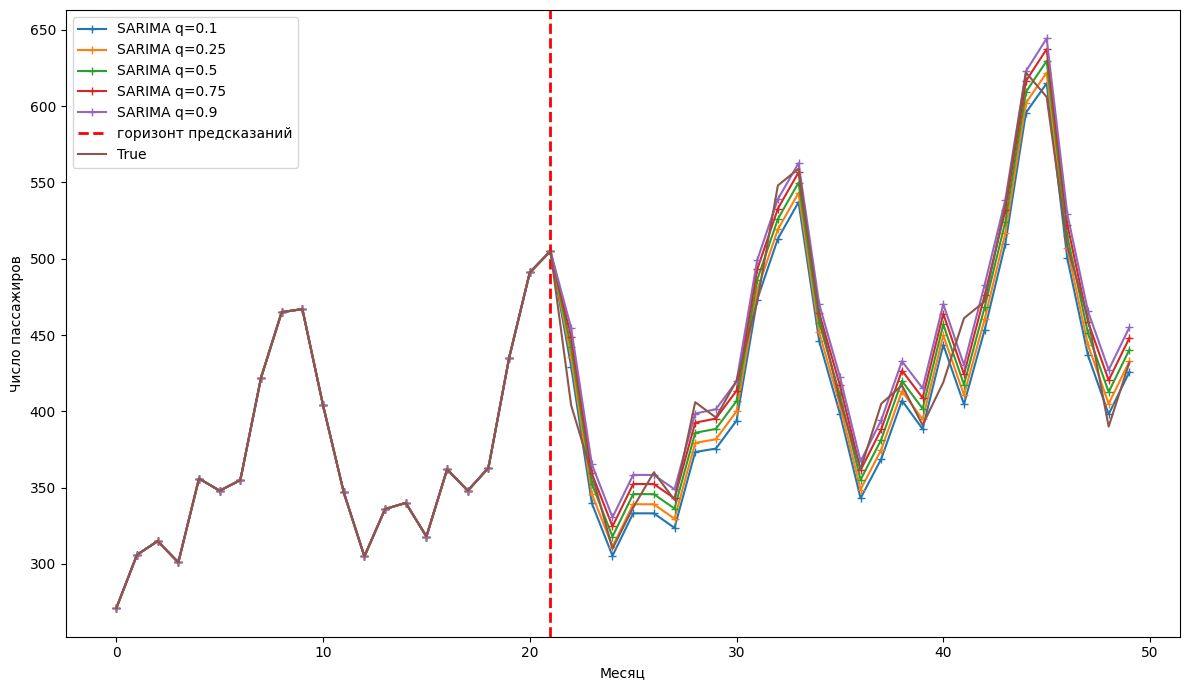

RMSE: 17.8524
R2: 0.9483
MAE: 14.2756



In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss
pl = PinballLoss(score_average=False)
print(f'rolling pl: {pl(y[-28:], rolling_quantile_pred).to_numpy()}\n')

plt.figure(figsize=(12, 7))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, list(rolling_quantile_pred.to_dict()[(0, quantile)].values())))[-50:], '+-',label=f'SARIMA q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('Месяц')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

print(f'RMSE: {root_mean_squared_error(y_true=y[-28:], y_pred=rolling_pred):.4f}')
print(f"R2: {r2_score(y_true=y[-28:], y_pred=rolling_pred):.4f}")
print(f"MAE: {mean_absolute_error(y[-28:], y_pred=rolling_pred):.4f}\n")

# CatBoost

In [ ]:
y = DATA
lags=[1, 2, 3, 7, 14, 30]
rolling_windows=[3, 7, 14, 30]
diff_periods=[1, 2, 3, 7, 14, 30]

df = pd.DataFrame({'target': y})
    
for lag in lags:
    df[f'lag_{lag}'] = df['target'].shift(lag)

for window in rolling_windows:
    df[f'rolling_mean_{window}'] = df['target'].shift(1).rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['target'].shift(1).rolling(window=window).std()


for period in diff_periods:
    df[f'diff_{period}'] = df['target'].diff(period)

df['target_future'] = df['target'].shift(-1)
df = df.iloc[:-1]

# df = df.dropna() #########3
display(df.shape)
display(df.head())

X = df.drop(columns=['target', 'target_future'])
y_target = df['target_future']

X_train, X_test = X[:-28], X[-28:]
y_train, y_test = y_target[:-28], y_target[-28:]
print(f"\nРазмеры данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

(143, 22)

,target,lag_1,lag_2,lag_3,lag_7,lag_14,lag_30,rolling_mean_3,rolling_std_3,rolling_mean_7,...,rolling_std_14,rolling_mean_30,rolling_std_30,diff_1,diff_2,diff_3,diff_7,diff_14,diff_30,target_future
0,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.0
1,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,132.0
2,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.0,20.0,NaN,NaN,NaN,NaN,129.0
3,129,132.0,118.0,112.0,NaN,NaN,NaN,120.666667,10.263203,NaN,...,NaN,NaN,NaN,-3.0,11.0,17.0,NaN,NaN,NaN,121.0
4,121,129.0,132.0,118.0,NaN,NaN,NaN,126.333333,7.371115,NaN,...,NaN,NaN,NaN,-8.0,-11.0,3.0,NaN,NaN,NaN,135.0



Размеры данных:
X_train: (115, 20), y_train: (115,)
X_test: (28, 20), y_test: (28,)


In [25]:
from catboost import CatBoostRegressor
models = {}
predictions = {}
rolling_predictions = {}
eval_results = {}

param_grid = {
    'depth': [3, 4, 5, 6],                    # Глубина деревьев
    'l2_leaf_reg': [1, 3, 5, 7, 10],          # L2 регуляризация
    'learning_rate': [0.01, 0.05, 0.1], # Скорость обучения
    'iterations': [500, 1000, 1500],           # Количество итераций
    'random_strength': [0.1, 0.5, 1],         # Случайность при выборе разделений
    'bagging_temperature': [0, 0.5, 1],       # Температура бэггинга
    'leaf_estimation_iterations': [1, 5, 10], # Итерации для оценки листьев
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'] # Стратегия роста
}

for alpha in QUANTILES:
    print(f"\nОбучаем CatBoost для квантиля {alpha}...")
    task_type = 'CPU'
    try:
        import torch
        task_type = 'GPU' if torch.cuda.is_available() else 'CPU'
    except Exception as e:
        print(str(e))
    print(f'Catboost task_type={task_type}')

    model = CatBoostRegressor(
        loss_function=f'Quantile:alpha={alpha}',
        iterations=50_000,
        learning_rate=1e-2,
        depth=3,
        l2_leaf_reg=3,
        random_seed=SEED,
        verbose=100,  # Показываем прогресс каждые 100 итераций
        early_stopping_rounds=2_000,
        task_type=task_type,  # Можно изменить на 'GPU' если есть 
        train_dir = '../output/catboost_info'
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=False,  # Можно установить True для визуализации обучения
        verbose_eval=0
    )
    predictions[alpha] = model.predict(X_test)
    models[alpha] = model

    horizon=4 if cfg.SERIES_TYPE == 'PASSENGERS' else 7
    rolling_pred = [model.predict(X_test[:horizon])]
    for i in tqdm(range(len(y_train) + horizon, len(y_target), horizon)):
        model.fit(
            X[:i], y_target[:i],
            eval_set=(X[i:], y_target[i:]),
            plot=False,  # Можно установить True для визуализации обучения
            verbose_eval=0
        )
        rolling_pred.append(model.predict(X[i:i+horizon]))
    rolling_predictions[alpha] = np.concatenate(rolling_pred)
    
    
    


Обучаем CatBoost для квантиля 0.05...
No module named 'torch'
Catboost task_type=CPU


NameError: name 'X_train' is not defined

HORIZON 28
pl alpha=0.1: 7.944949005164318
pl alpha=0.25: 13.625716008311969
pl alpha=0.5: 24.973832231448263
pl alpha=0.75: 30.330672847565076
pl alpha=0.9: 30.018496977442826
ROLLING HORIZON 4
pl alpha=0.1: 5.630209393837179
pl alpha=0.25: 11.16621531242849
pl alpha=0.5: 16.79324686372591
pl alpha=0.75: 18.612690595235474
pl alpha=0.9: 18.094659880309443


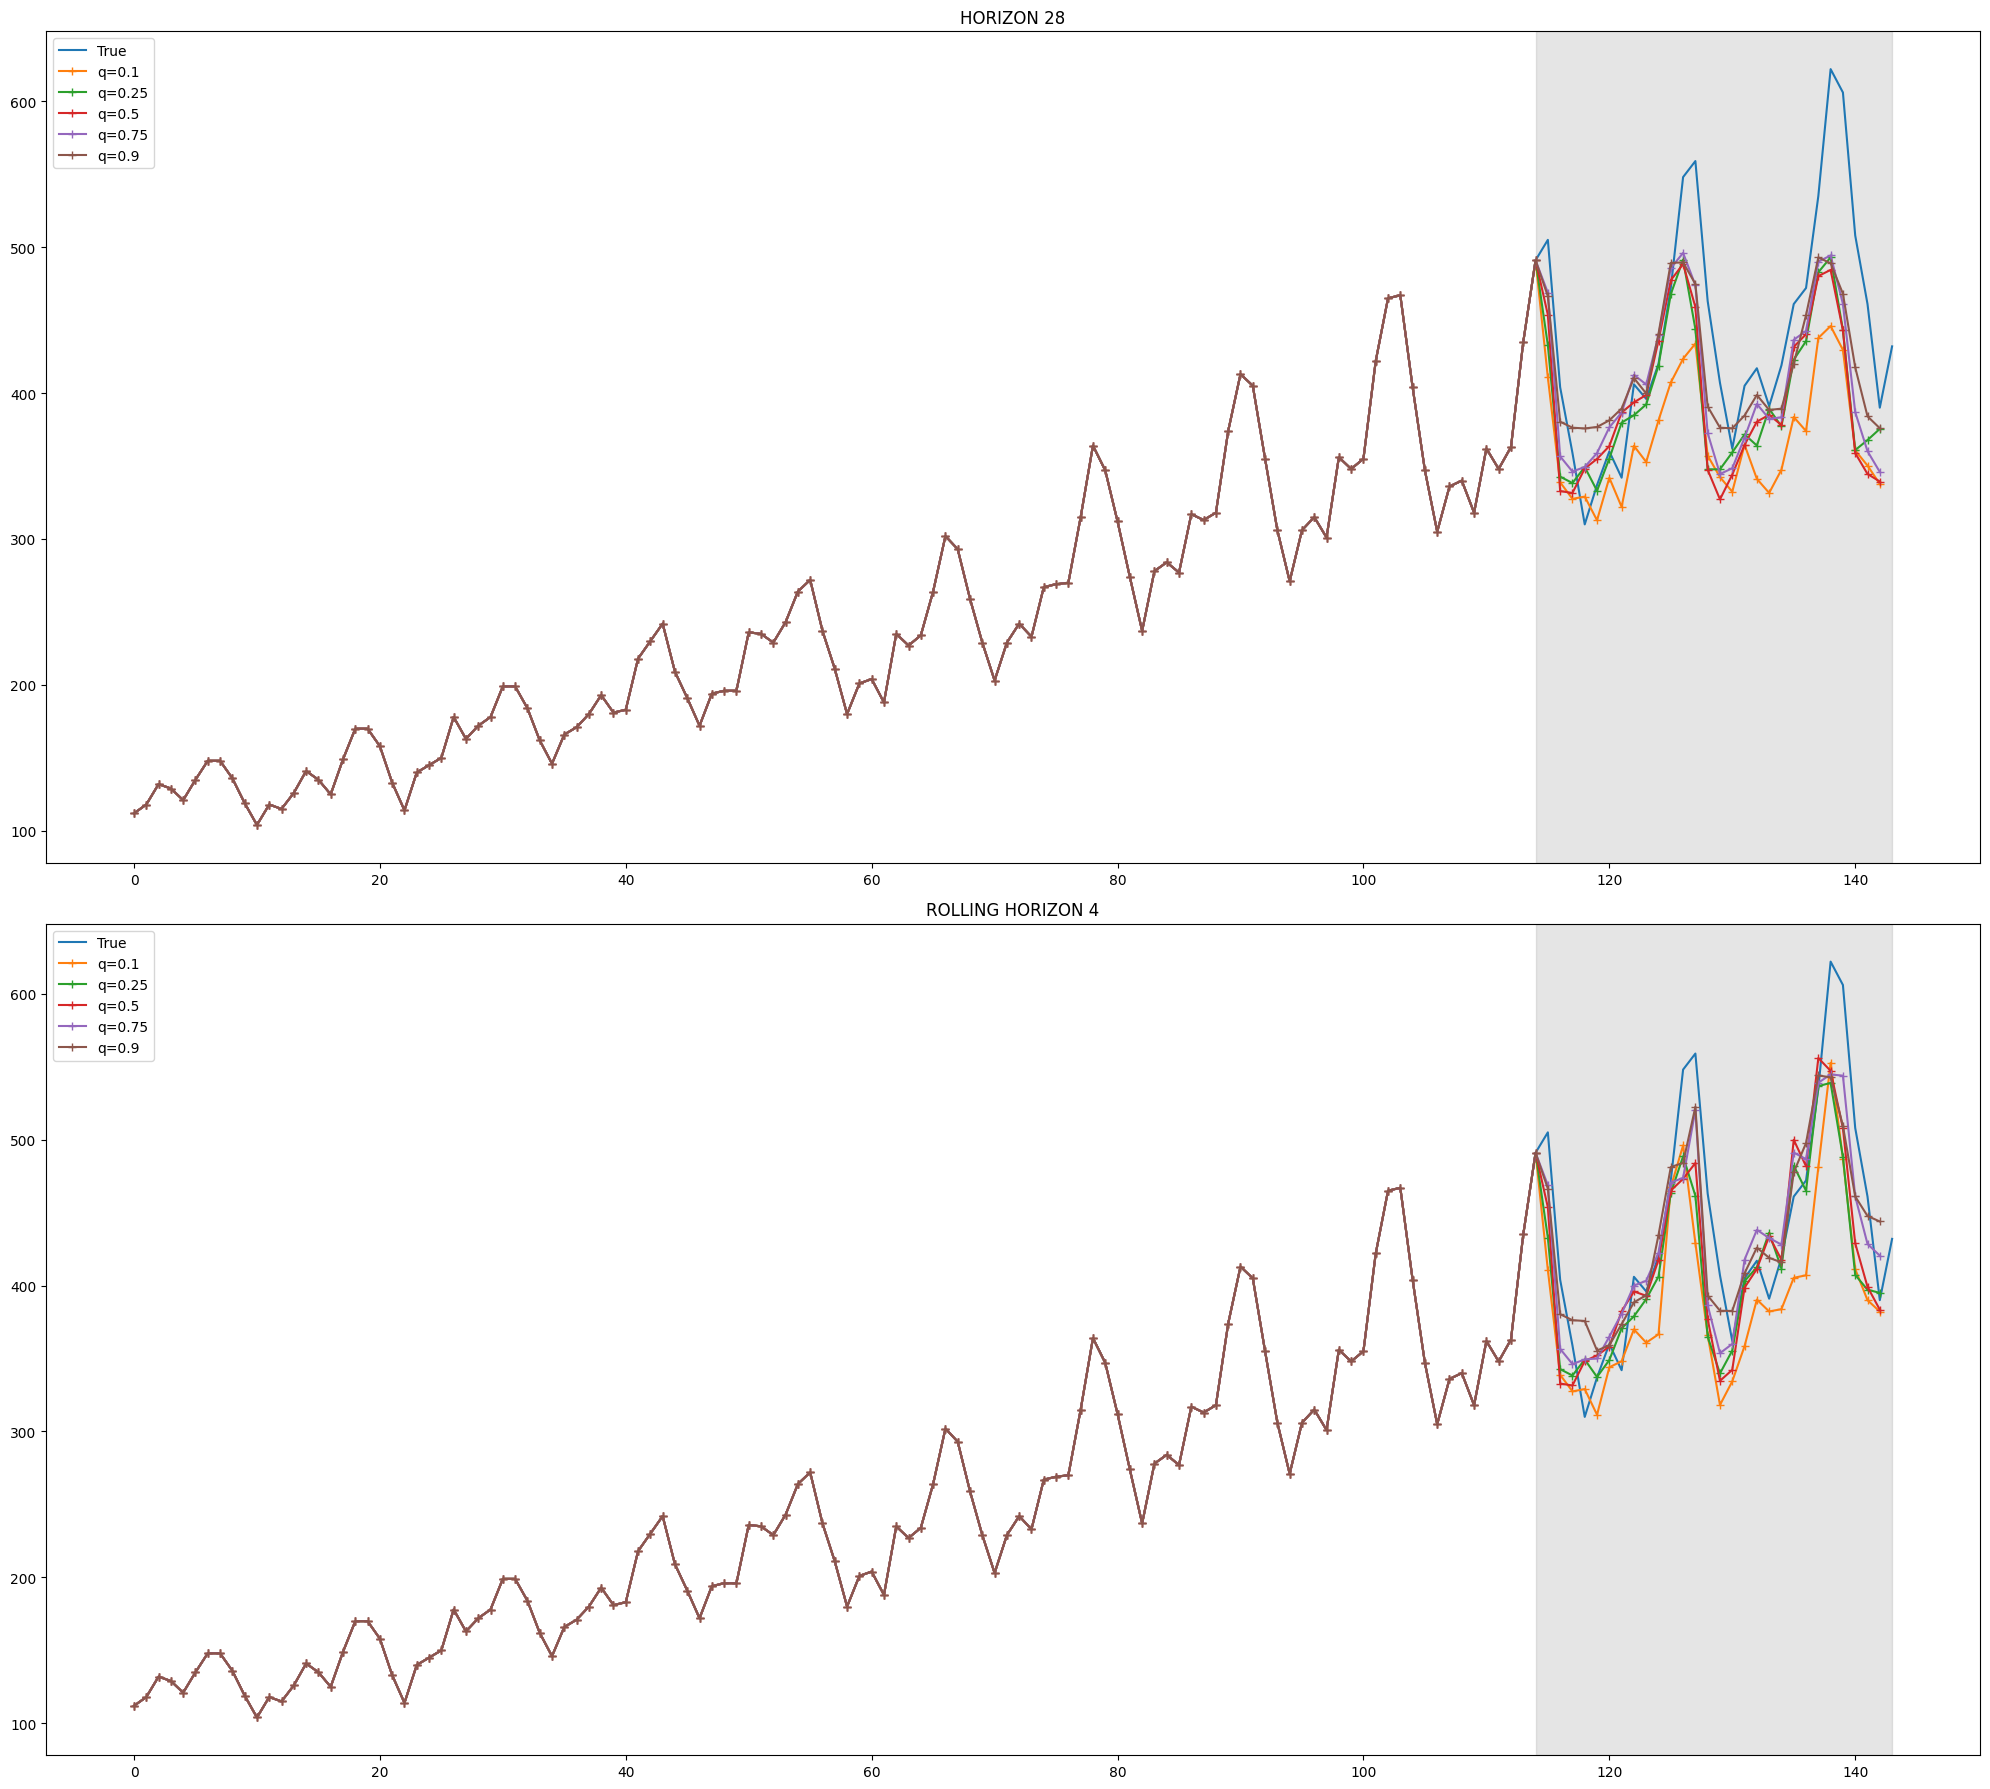

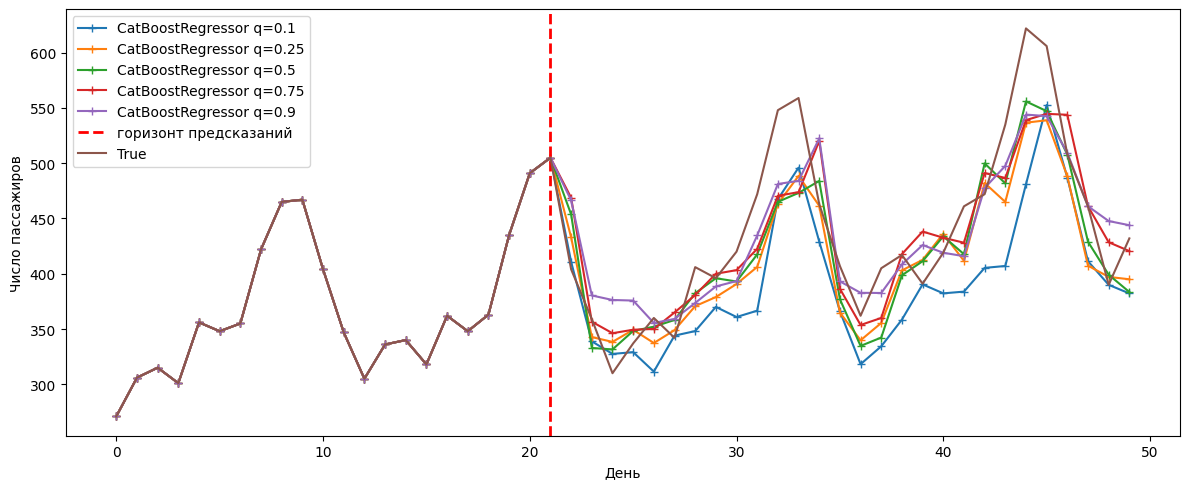

In [ ]:
from sklearn.metrics import mean_pinball_loss, mean_absolute_error

print('HORIZON 28')
for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y_test, predictions[quantile], alpha=quantile)}')

print(f"ROLLING HORIZON {horizon}")
for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y[-28:], rolling_predictions[quantile], alpha=quantile)}')


fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(y, label='True')
ax[0].set_title('HORIZON 28')
for quantile in QUANTILES:
    ax[0].plot(np.concatenate((df["target"][:-28], predictions[quantile])), '+-',label=f'q={quantile}')
ax[0].axvspan(len(y_train) - 1, len(y) - 1, color='#808080', alpha=0.2)
ax[0].legend()

ax[1].plot(y, label='True')
ax[1].set_title(f"ROLLING HORIZON {horizon}")
for quantile in QUANTILES:
    ax[1].plot(np.concatenate((df["target"][:-28], rolling_predictions[quantile])), '+-',label=f'q={quantile}')
ax[1].axvspan(len(y_train) - 1, len(y) - 1, color='#808080', alpha=0.2)
ax[1].legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, list(rolling_predictions[quantile])))[-50:], '+-',label=f'CatBoostRegressor q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('День')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()


# ETS

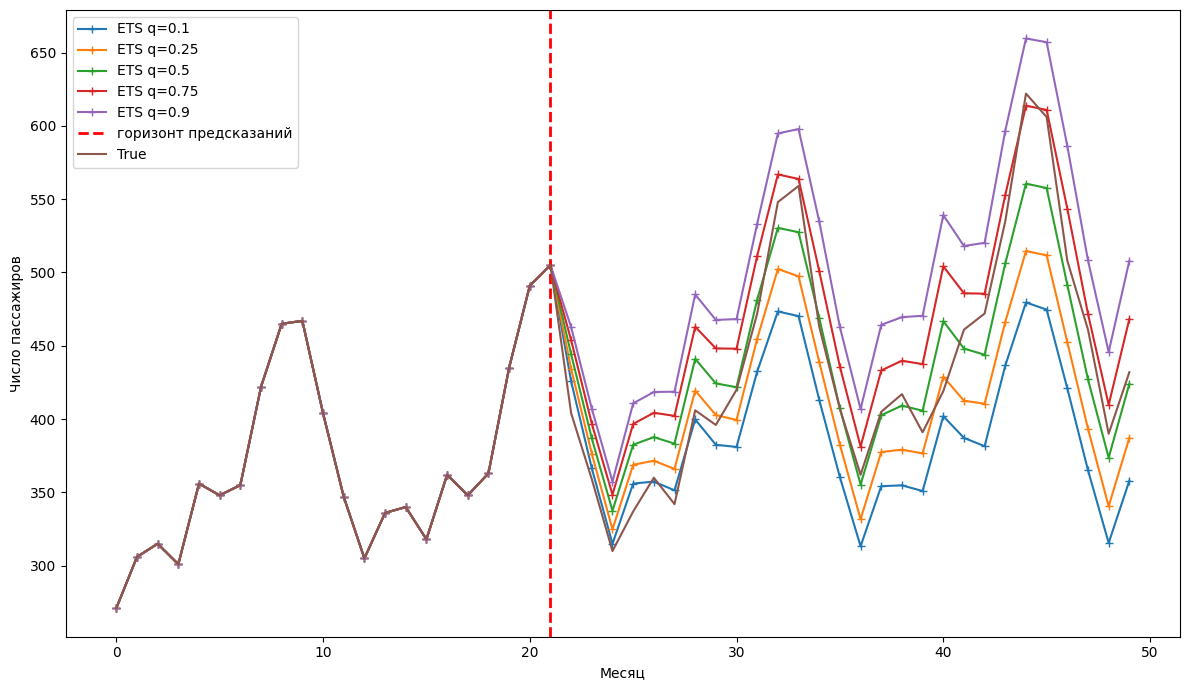

RMSE: 27.5191
R2: 0.8772
MAE: 22.5529


Результаты Pinball Loss:
Quantile 0.1: 54.8249
Quantile 0.25: 45.6875
Quantile 0.5: 30.4583
Quantile 0.75: 15.2292
Quantile 0.9: 6.0917


In [ ]:
from sktime.forecasting.ets import AutoETS
sp = 7 if cfg.SERIES_TYPE == "M5" else 12
model = AutoETS(auto=True, sp=sp, maxiter=10_000, random_state=173)
y = DATA
train_data = y[:-FORECAST_HORIZON]
model.fit(train_data)
ets_pred = model.predict(fh=np.arange(1, 28+1)).flatten()
ets_quantile_pred = model.predict_quantiles(fh=np.arange(1, 28+1), alpha=QUANTILES)


# Вспомогательная функция для извлечения из sktime DataFrame, если нужно
def get_sktime_preds(sktime_res, q):
    # sktime часто возвращает мультииндекс (coverage, quantile)
    # Адаптируйте индекс (0, q) под вашу версию sktime, если он отличается
    return list(sktime_res.to_dict()[(0, q)].values())

plt.figure(figsize=(12, 7))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, get_sktime_preds(ets_quantile_pred, quantile)))[-50:], '+-',label=f'ETS q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('Месяц')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_pinball_loss

print(f'RMSE: {root_mean_squared_error(y_true=y[-FORECAST_HORIZON:], y_pred=ets_pred):.4f}')
print(f"R2: {r2_score(y_true=y[-FORECAST_HORIZON:], y_pred=ets_pred):.4f}")
print(f"MAE: {mean_absolute_error(y[-FORECAST_HORIZON:], y_pred=ets_pred):.4f}\n")

print("\nРезультаты Pinball Loss:")
for q in QUANTILES:
    loss = mean_pinball_loss(y[-FORECAST_HORIZON:], get_sktime_preds(ets_quantile_pred, quantile), alpha=q)
    print(f"Quantile {q}: {loss:.4f}")

# TBATS

Обучение TBATS (это может занять время)...


d:\quantile_regression\m5-forecasting-uncertainty\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\quantile_regression\m5-forecasting-uncertainty\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\quantile_regression\m5-forecasting-uncertainty\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\quantile_regression\m5-forecasting-uncertainty\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\quantile_regression\m5-forecasting-uncertainty\.venv\lib\site-packages\sklearn\ut

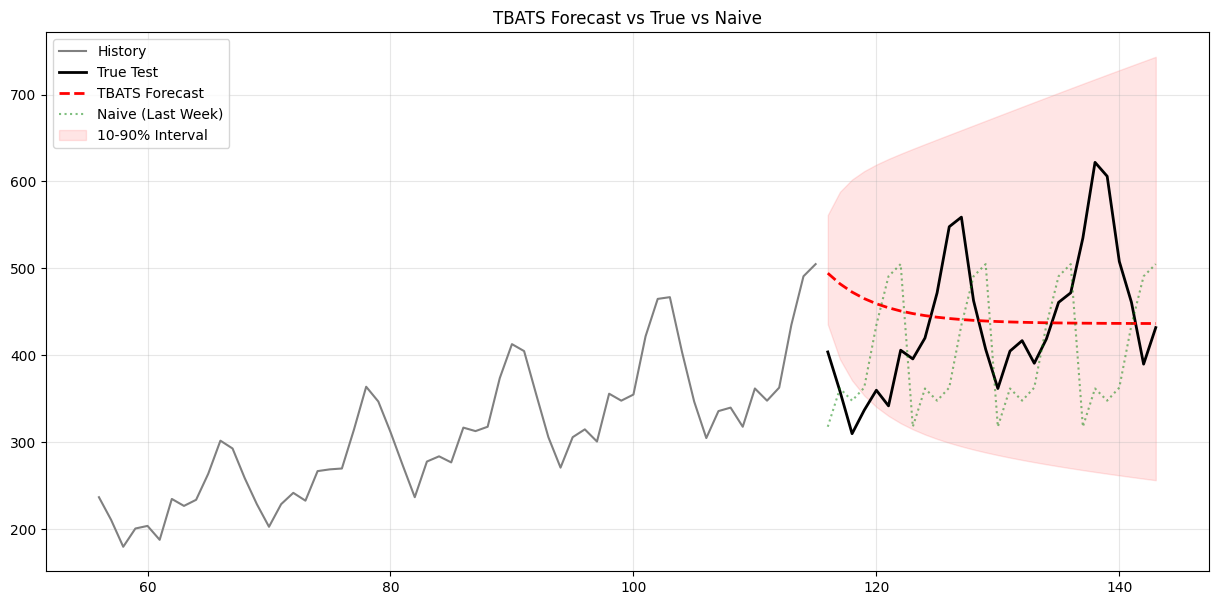

Metric     | TBATS      | Naive (Benchmark)
-----------------------------------
RMSE       | 87.3991    | 113.7076  
MAE        | 71.4719    | 89.7857   

TBATS Pinball Loss:
Q 0.1 : 18.9170
Q 0.25: 32.5163
Q 0.5 : 35.7360
Q 0.75: 32.4316
Q 0.9 : 23.1663

AVERAGE Pinball Loss: 28.5534


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Используем TBATS вместо AutoETS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.naive import NaiveForecaster # Для сравнения (бенчмарк)

from sklearn.metrics import mean_pinball_loss, root_mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

# --- 1. Подготовка данных ---
y = DATA
if isinstance(y, np.ndarray):
    y = pd.Series(y)

# Отрезаем слишком старую историю, если она вносит шум. 
# Для M5 часто последние 1-2 года работают лучше, чем все 5 лет.
# Попробуем взять последние 730 дней (2 года) для обучения.
CUTOFF = 730 
if len(y) > CUTOFF + FORECAST_HORIZON:
    y_cut = y.iloc[-CUTOFF:]
else:
    y_cut = y

# Разбиение
test_split_idx = len(y_cut) - FORECAST_HORIZON
y_train = y_cut.iloc[:test_split_idx]
y_test = y_cut.iloc[test_split_idx:]

# --- 2. Обучение модели TBATS ---
# use_boxcox=True: Автоматически стабилизирует дисперсию (заменяет наш ручной Log)
# use_trend=True: Включает тренд
# use_damped_trend=True: Затухающий тренд (важно для горизонта 28 дней)
# sp=[7, 30]: Указываем недельную и месячную сезонность (365 может быть слишком долго считаться)

print("Обучение TBATS (это может занять время)...")

# В sktime параметр называется 'sp', а не 'seasonal_periods'
model = TBATS(
    use_box_cox=True,          # Используем преобразование Бокса-Кокса
    use_trend=True,            # Используем тренд
    use_damped_trend=True,     # Используем затухающий тренд
    sp=[7, 30],                # <--- ИСПРАВЛЕНО: sp вместо seasonal_periods
    n_jobs=-1
)

model.fit(y_train)
# --- 3. Прогноз ---
fh = np.arange(1, FORECAST_HORIZON + 1)

# Точечный прогноз
y_pred = model.predict(fh=fh)

# Квантильный прогноз (TBATS генерирует интервалы)
# В sktime для TBATS predict_quantiles может быть не реализован напрямую или работать медленно.
# Если он не сработает, мы используем predict_interval и аппроксимируем квантили.
try:
    pred_quantiles_df = model.predict_quantiles(fh=fh, alpha=QUANTILES)
    # Функция для извлечения
    def get_quantile_preds(q):
        return pred_quantiles_df.iloc[:, pred_quantiles_df.columns.get_level_values(-1) == q].values.flatten()
except:
    print("Внимание: predict_quantiles не поддерживается, используем аппроксимацию через интервалы.")
    # Аппроксимация (грубая) через нормальное распределение ошибок, которое TBATS предполагает
    pred_ints = model.predict_interval(fh=fh, coverage=0.9) # берем широкий интервал
    # Это заглушка, лучше использовать модель, которая поддерживает квантили нативно, если TBATS откажет
    # Но обычно в свежих версиях sktime это работает.
    raise NotImplementedError("Обновите sktime или используйте симуляцию.")

# --- 4. БЕНЧМАРК (Сезонное наивное) ---
# Чтобы понять, насколько всё плохо, сравним с тупой моделью "как на прошлой неделе"
naive_model = NaiveForecaster(strategy="last", sp=7)
naive_model.fit(y_train)
y_pred_naive = naive_model.predict(fh=fh)

# --- 5. Визуализация ---
plt.figure(figsize=(15, 7))
plot_start = len(y_train) - 60

# История
plt.plot(np.arange(plot_start, len(y_train)), y_train.iloc[plot_start:], label='History', color='gray')
# Истина
plt.plot(np.arange(len(y_train), len(y_cut)), y_test, label='True Test', color='black', linewidth=2)
# Прогноз TBATS
plt.plot(np.arange(len(y_train), len(y_cut)), y_pred, '--', label='TBATS Forecast', color='red', linewidth=2)
# Прогноз Naive
plt.plot(np.arange(len(y_train), len(y_cut)), y_pred_naive, ':', label='Naive (Last Week)', color='green', alpha=0.5)

# Рисуем границы 10% и 90% квантилей для TBATS
q10 = get_quantile_preds(0.1)
q90 = get_quantile_preds(0.9)
x_fut = np.arange(len(y_train), len(y_cut))
plt.fill_between(x_fut, q10, q90, color='red', alpha=0.1, label='10-90% Interval')

plt.title('TBATS Forecast vs True vs Naive')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 6. Метрики ---
print(f"{'Metric':<10} | {'TBATS':<10} | {'Naive (Benchmark)':<10}")
print("-" * 35)

rmse_tbats = root_mean_squared_error(y_test, y_pred)
rmse_naive = root_mean_squared_error(y_test, y_pred_naive)
print(f"{'RMSE':<10} | {rmse_tbats:<10.4f} | {rmse_naive:<10.4f}")

mae_tbats = mean_absolute_error(y_test, y_pred)
mae_naive = mean_absolute_error(y_test, y_pred_naive)
print(f"{'MAE':<10} | {mae_tbats:<10.4f} | {mae_naive:<10.4f}")

# Pinball Loss
print("\nTBATS Pinball Loss:")
mean_pb_loss = []
for q in QUANTILES:
    pq = get_quantile_preds(q)
    # Обрезаем отрицательные прогнозы, так как продажи не могут быть < 0
    pq = np.maximum(pq, 0) 
    loss = mean_pinball_loss(y_test, pq, alpha=q)
    mean_pb_loss.append(loss)
    print(f"Q {q:<4}: {loss:.4f}")
    
print(f"\nAVERAGE Pinball Loss: {np.mean(mean_pb_loss):.4f}")

# Подготовка данных для винцентизации (сохраняем в переменную)
tbats_quantile_pred = pred_quantiles_df

# Vincentization

In [ ]:
import os
from utils.evaluation import evaluate_model_combinations

# 1. Подготовка данных (собираем всё в один словарь)
# Убедитесь, что все массивы одной длины (FORECAST_HORIZON точек)

models_data = {
    'ARIMA': {},
    'CatBoost': {},
    'Prophet': {},
    'TBAST': {},
    'ETS': {}
}

for q in QUANTILES:
    # ARIMA (из sktime)
    # Важно: берем последние FORECAST_HORIZON точек, если там больше
    arima_vals = get_sktime_preds(rolling_quantile_pred, q)
    models_data['ARIMA'][q] = arima_vals[-FORECAST_HORIZON:] 
    
    # Предполагаем, что там numpy array
    # models_data['CatBoost'][q] = rolling_predictions[q][-FORECAST_HORIZON:]
    
    # Prophet (ваш словарь prophet_quantile_predictions)
    models_data['Prophet'][q] = prophet_quantile_predictions[q][-FORECAST_HORIZON:]

    # models_data["TBAST"][q] = get_sktime_preds(tbats_quantile_pred, q)
    models_data["ETS"][q] = get_sktime_preds(ets_quantile_pred, q)


# 2. Запуск функции
# y_test[-FORECAST_HORIZON:] - это истинные значения за последние FORECAST_HORIZON дней
styled_table = evaluate_model_combinations(y_test[-FORECAST_HORIZON:], models_data, QUANTILES, y_train=DATA[:-FORECAST_HORIZON])

# 3. Отображение таблицы
os.makedirs('output/aggregation_results', exist_ok=True)
with open(f"output/{cfg.SERIES_TYPE}_{SERIES_ID}_vinc.html", 'w') as f:
    styled_table.to_html(f)
styled_table

Используется M5 Scale: 21.0000
Квантиль   | Лучшая одиночная модель        | Лучшая комбинация (Overall)   
--------------------------------------------------------------------------------
0.1        | ARIMA                  (0.1838) | ARIMA + Prophet        (0.1626)
0.25       | ARIMA                  (0.2793) | ARIMA + Prophet        (0.2476)
0.5        | ARIMA                  (0.3399) | ARIMA + Prophet        (0.2847)
0.75       | ARIMA                  (0.2591) | ARIMA + Prophet        (0.2285)
0.9        | ARIMA                  (0.1598) | ARIMA + Prophet        (0.1241)



,ARIMA,ETS,Prophet,ARIMA + ETS,ARIMA + Prophet,Prophet + ETS,ARIMA + Prophet + ETS
0.100000,0.1838,0.3419,0.1925,0.2113,0.1626,0.2489,0.2004
0.250000,0.2793,0.5872,0.3298,0.3483,0.2476,0.4576,0.3369
0.500000,0.3399,0.5730,0.3849,0.3561,0.2847,0.4772,0.3614
0.750000,0.2591,0.4028,0.2965,0.2515,0.2285,0.3142,0.2396
0.900000,0.1598,0.2901,0.1715,0.1741,0.1241,0.1885,0.1450


# Defining of corresponding time series

In [ ]:
# N_SERIES_TO_PROCESS = 1000
# sample_df = train_df.iloc[[30426, 0]]
# SEASONAL_PERIOD = 365  # Данные в M5 ежедневные, основная сезонность - недельная
# THRESHOLDS = {
#         'trend': 0.8,     # Сила тренда > 0.5 -> есть тренд
#         'season': 0.7,    # Сила сезонности > 0.5 -> есть сезонность
#         'clean': 0.85,     # Сила компоненты > 0.9 -> компонент "чистый" (мало шума)
#     }

# results = []
# for index, row in sample_df.iterrows():
#     series_id = row['id']
#     # Отбираем только столбцы с продажами (d_1, d_2, ...)
#     time_series = row.filter(like='d_').astype(float)
    
#     features = calculate_stl_features(time_series, period=SEASONAL_PERIOD)

#     if features:
#         classification = classify_series(features, THRESHOLDS)
#         results.append({
#             'id': series_id,
#             'classification': classification,
#             'trend_strength': features['trend_strength'],
#             'seasonal_strength': features['seasonal_strength'],
#             'noise_variance': features['noise_variance'],
#             'stl_result': features['stl_result'] # Сохраняем объект для графика
#         })

# stl_results_df = pd.DataFrame(results)
# print("--- Результаты классификации ---")
# display(stl_results_df[['id', 'classification', 'trend_strength', 'seasonal_strength']].head(10))
# print("\n--- Сводка по категориям ---")
# display(stl_results_df['classification'].value_counts())

# # ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ
# print("\n--- Визуализация примеров из каждой найденной категории ---")

# unique_classifications = stl_results_df['classification'].unique()
# for cat in unique_classifications:
#     # Находим первый ряд, соответствующий этой категории
#     example = stl_results_df[stl_results_df['classification'] == cat].iloc[0]
    
#     print(f"\nПример для категории: '{cat}' (ID: {example['id']})")
    
#     # Отрисовываем его STL-декомпозицию
#     fig = example['stl_result'].plot()
#     fig.suptitle(f"Категория: {cat}\nID: {example['id']}", y=1.02)
#     plt.show()

In [ ]:
# stl_results_df["classification"].value_counts()

In [ ]:
# classification_res = "Seasonality + Noise"
# indx_lst = []
# for id in stl_results_df[stl_results_df["classification"] == classification_res]["id"].values:
#     index = train_df[train_df["id"] == id].index.item()
#     indx_lst.append(index)
# display(stl_results_df[stl_results_df["classification"] == classification_res]["id"])
# print(indx_lst)
# plot_series(indx_lst)
# # plt.plot(train_df[train_df["id"] == "HOBBIES_1_003_CA_1_evaluation"].values)

